In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/content/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

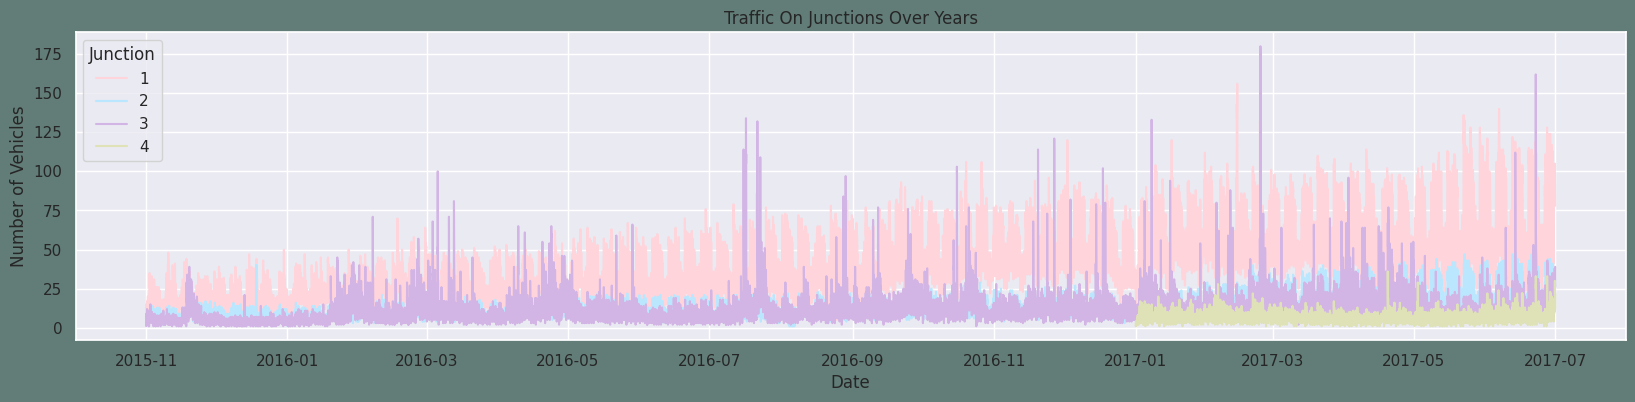

In [ ]:
sns.set_theme()

df=data.copy()
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


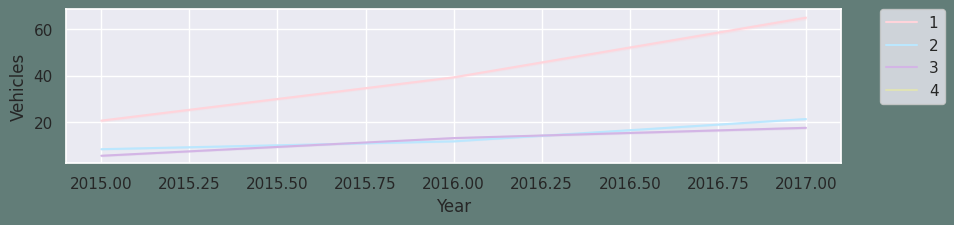

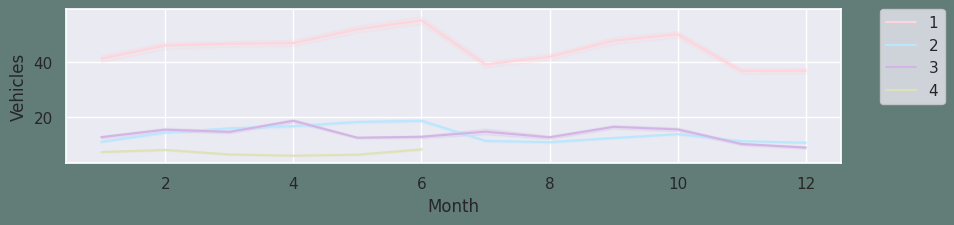

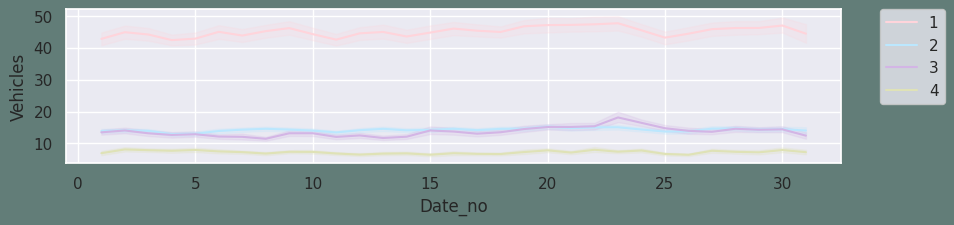

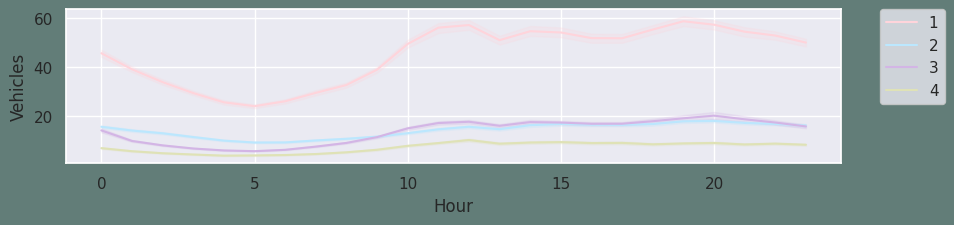

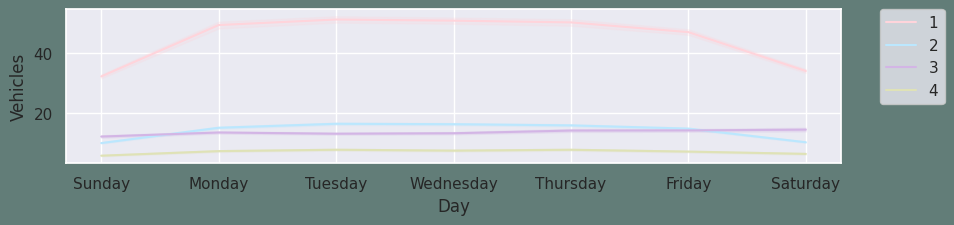

In [ ]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

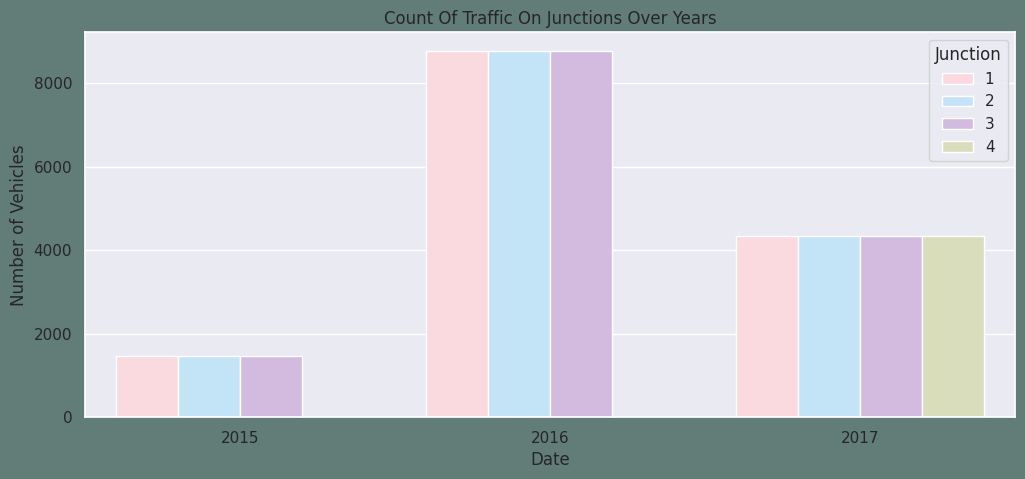

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df['DateTime'] = pd.to_datetime(df['DateTime']).astype(int) / 10**9


<Axes: >

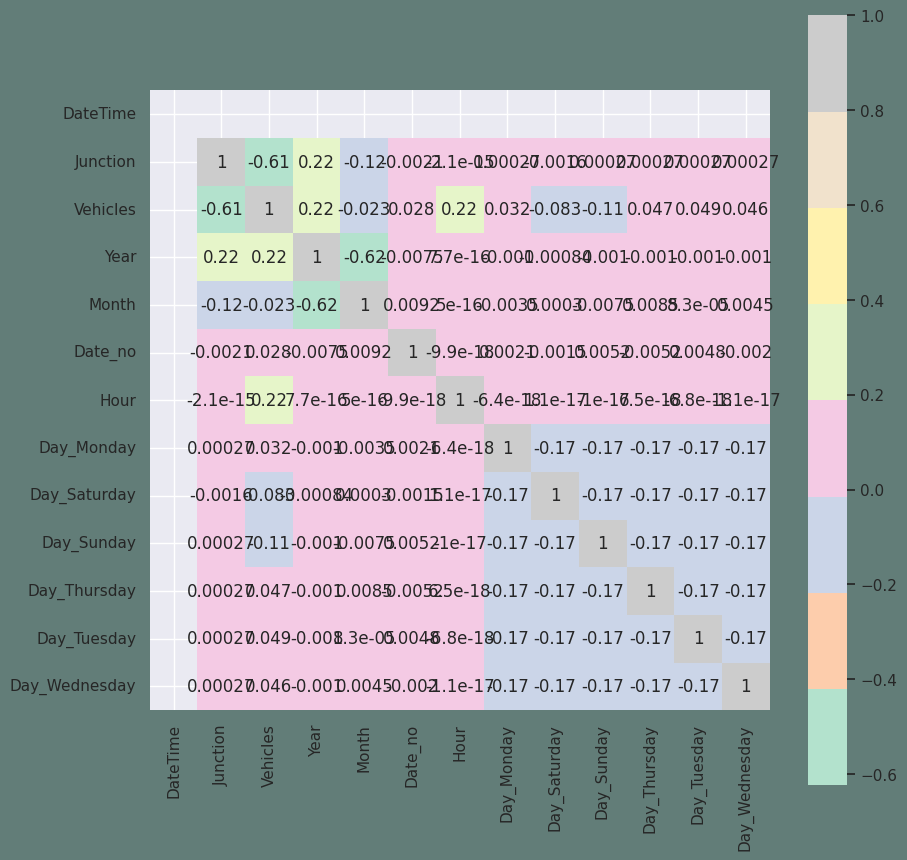

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

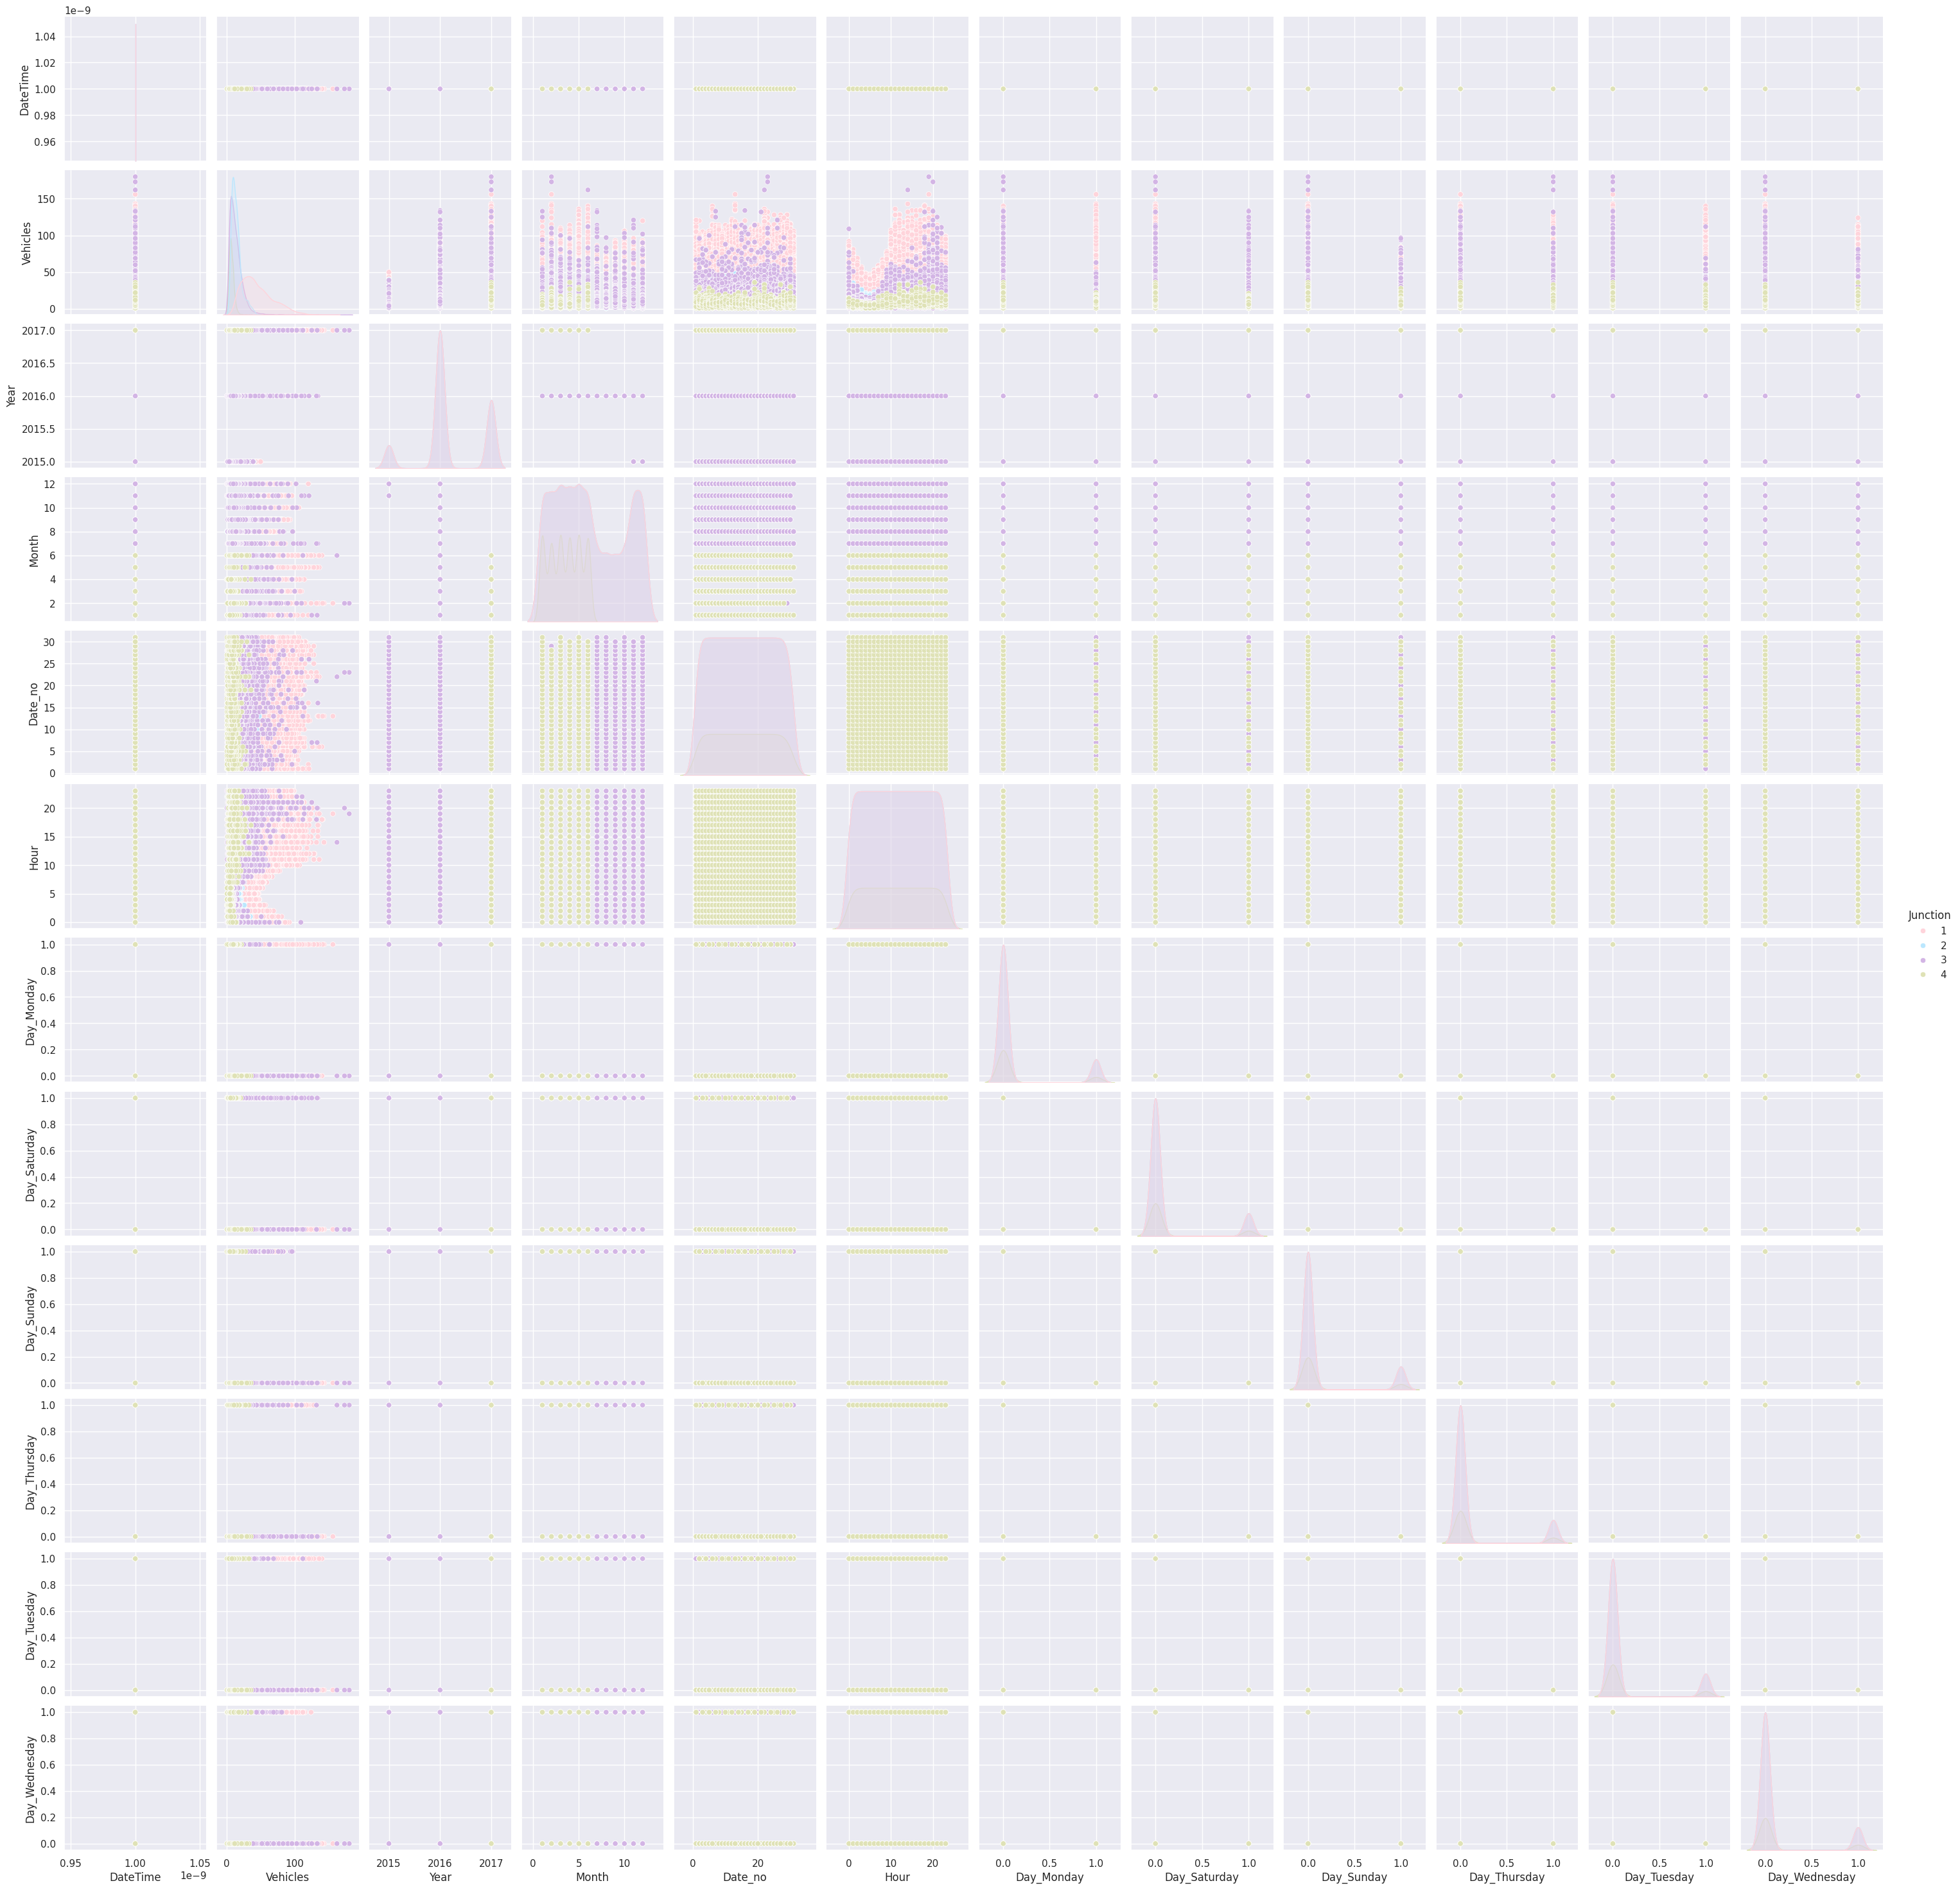

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [ ]:
df_J

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

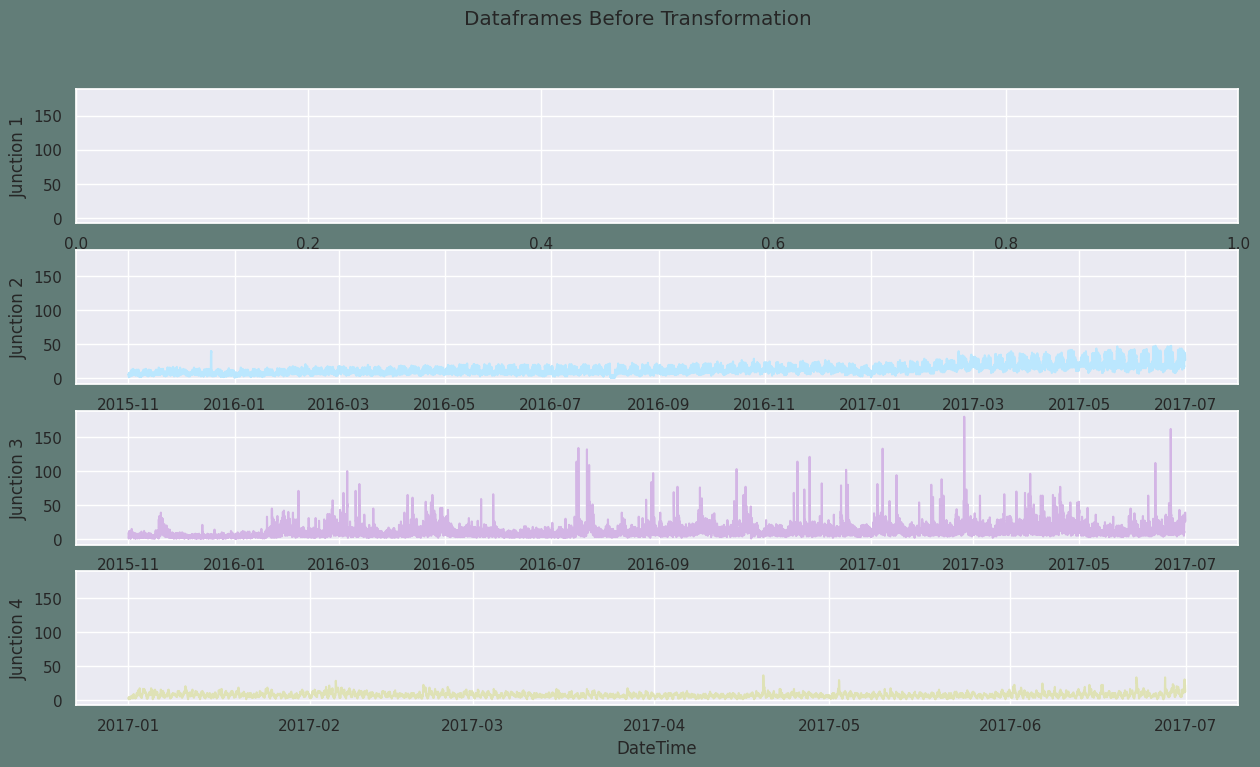

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna()

list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    #pl_1=plt.()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df[ col ] = df_normalized
    df_normalized = df_normalized.to_frame()
    return df, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
df = df.set_index( ["DateTime"])

In [ ]:
df = df[ df[ "Junction" ] == 1]

In [ ]:
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
DateTime,,,,,,,,,,,,
1.000000e-09,1,15,2015,11,1,0,False,False,True,False,False,False
1.000000e-09,1,13,2015,11,1,1,False,False,True,False,False,False
1.000000e-09,1,10,2015,11,1,2,False,False,True,False,False,False
1.000000e-09,1,7,2015,11,1,3,False,False,True,False,False,False
1.000000e-09,1,9,2015,11,1,4,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1.000000e-09,1,105,2017,6,30,19,False,False,False,False,False,False
1.000000e-09,1,96,2017,6,30,20,False,False,False,False,False,False
1.000000e-09,1,90,2017,6,30,21,False,False,False,False,False,False


In [ ]:
df.dtypes


Junction         int64
Vehicles         int64
Year             int32
Month            int32
Date_no          int32
Hour             int32
Day_Monday        bool
Day_Saturday      bool
Day_Sunday        bool
Day_Thursday      bool
Day_Tuesday       bool
Day_Wednesday     bool
dtype: object

In [ ]:
df.dtypes
df[ "Day" ] = df[ "Day" ].astype( str ).replace( { "Monday" : 1 , "Tuesday" : 2 , "Wednesday" : 3 , "Thursday" : 4 , "Friday" : 5 , "Saturday" : 6 , "Sunday" : 7 } )

KeyError: 'DateTime'

In [ ]:
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
DateTime,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,7
2015-11-01 01:00:00,1,13,2015,11,1,1,7
2015-11-01 02:00:00,1,10,2015,11,1,2,7
2015-11-01 03:00:00,1,7,2015,11,1,3,7
2015-11-01 04:00:00,1,9,2015,11,1,4,7
...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,105,2017,6,30,19,5
2017-06-30 20:00:00,1,96,2017,6,30,20,5
2017-06-30 21:00:00,1,90,2017,6,30,21,5


In [ ]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) # week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) # hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) # hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

In [ ]:
df, av, std = Normalize(df, "Vehicles")
Diff = Difference(df, col="Vehicles", interval= ( 24 * 7 )) #taking an hour's diffrence
df = df[1:]
df.columns = [ i if i != "Vehicles" else "Norm" for i in df.columns]
#df["Diff"]= Diff

In [ ]:
df = df.tail( len( Diff))

df["Diff"]= Diff

In [ ]:
df.shape

(14424, 8)

In [ ]:
df


,Junction,Norm,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,,,
2015-11-08 00:00:00,1,-1.393099,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,1,-1.262712,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,1,-1.480024,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,1,-1.610412,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,1,-1.523487,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,2.605450,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,1,2.214288,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,1,1.953513,2017,6,30,21,5,0.391162


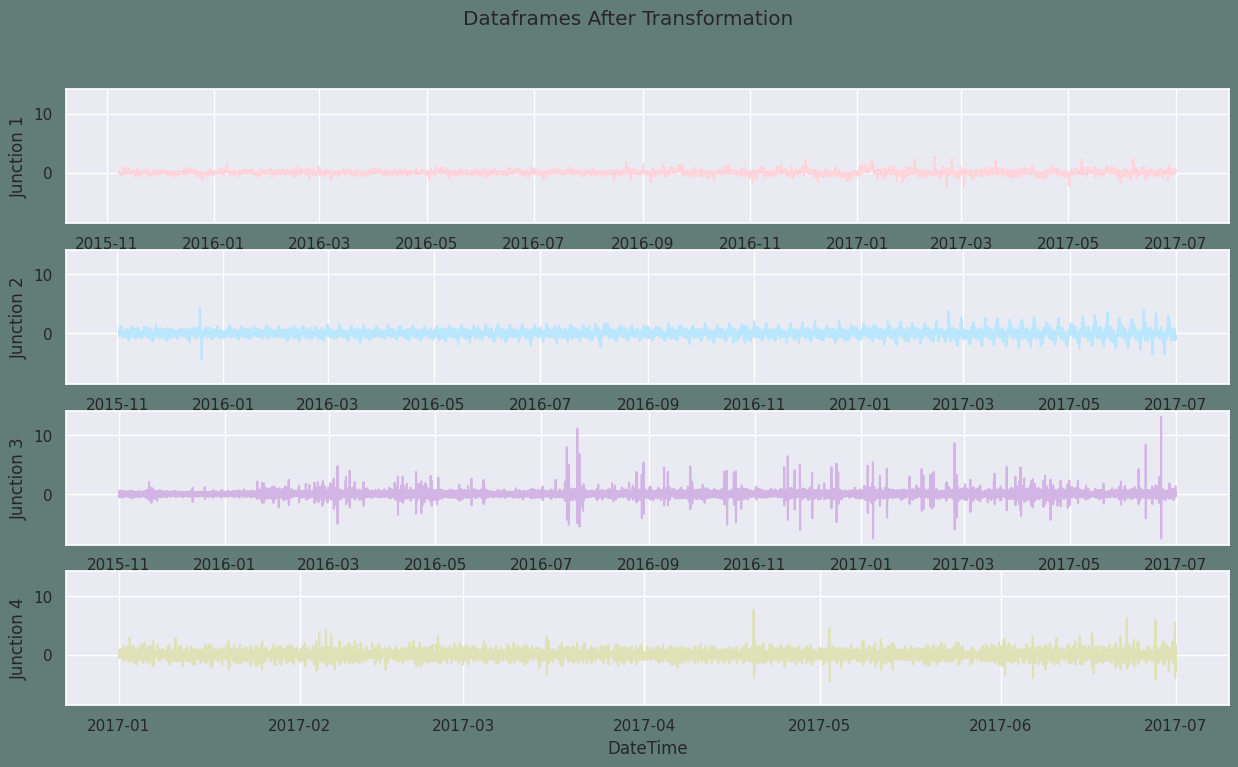

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


In [ ]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")



List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, df.shape[ 1 ]), test.values.reshape(-1, 1)
    return train, test

J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)


In [ ]:
df

,Junction,Norm,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,,,
2015-11-08 00:00:00,1,-1.393099,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,1,-1.262712,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,1,-1.480024,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,1,-1.610412,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,1,-1.523487,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,2.605450,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,1,2.214288,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,1,1.953513,2017,6,30,21,5,0.391162


In [ ]:
df = df.drop( [ "Junction" , "Norm" ] , axis = 1 )


In [ ]:
df

,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,
2015-11-08 00:00:00,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...
2017-06-30 19:00:00,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,2017,6,30,21,5,0.391162


In [ ]:
df = df.dropna()

J_train, J_test = Split_data(df)

In [ ]:
J_train

array([[ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         0.00000000e+00,  7.00000000e+00, -8.69249826e-02],
       [ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         1.00000000e+00,  7.00000000e+00,  1.30387474e-01],
       [ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         2.00000000e+00,  7.00000000e+00,  4.34624913e-02],
       ...,
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         1.80000000e+01,  1.00000000e+00, -7.82324843e-01],
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         1.90000000e+01,  1.00000000e+00, -6.51937369e-01],
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         2.00000000e+01,  1.00000000e+00, -5.21549895e-01]])

In [ ]:
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, :  ])
        y.append(df[i, -1 ])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 6))
    test = np.reshape(test, (test.shape[0],test.shape[1],6))
    return train, test